In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision import utils
import torchsummary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_dataset = CIFAR100('/content/', train=True, download=True, transform=transforms.ToTensor())
val_dataset = CIFAR100('/content/', train=False, download=True, transform=transforms.ToTensor())

print(len(train_dataset))
print(len(val_dataset))

100%|██████████| 169001437/169001437 [00:13<00:00, 12748494.14it/s]


Extracting /content/cifar-100-python.tar.gz to /content/
Files already downloaded and verified
50000
10000


In [4]:
train_meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train_dataset]
val_meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in val_dataset]

train_stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train_dataset]
val_stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in val_dataset]

print(np.array(train_meanRGB).shape)
print(np.array(val_meanRGB).shape)

print(np.array(train_stdRGB).shape)
print(np.array(val_stdRGB).shape)

(50000, 3)
(10000, 3)
(50000, 3)
(10000, 3)


In [5]:
train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])


train_stdR = np.mean([m[0] for m in train_stdRGB])
train_stdG = np.mean([m[1] for m in train_stdRGB])
train_stdB = np.mean([m[2] for m in train_stdRGB])

val_stdR = np.mean([m[0] for m in val_stdRGB])
val_stdG = np.mean([m[1] for m in val_stdRGB])
val_stdB = np.mean([m[2] for m in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

print(train_stdR, train_stdG, train_stdB)
print(val_stdR, val_stdG, val_stdB)

0.50707513 0.48654887 0.44091785
0.5087964 0.48739308 0.4419422
0.20079845 0.19834627 0.20219834
0.20184419 0.19985661 0.20355076


In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
    transforms.RandomHorizontalFlip()
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([val_meanR, val_meanG, val_meanB], [val_stdR, val_stdG, val_stdB]),
    transforms.RandomHorizontalFlip()
])

In [7]:
train_dataset.transform = train_transforms
val_dataset.transform = val_transforms

train_DL = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_DL = DataLoader(val_dataset, batch_size=32, shuffle=True)

Image Indicies [33003 12172  5192 32511]


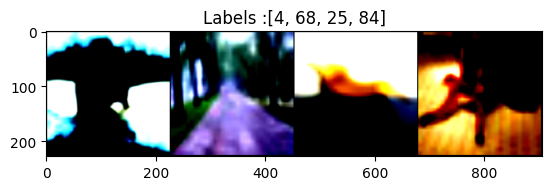

In [8]:
def imshow(img, y=None, color=True):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('Labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rand_idx = np.random.randint(0, len(train_dataset), grid_size)
print('Image Indicies', rand_idx)

x_grid = [train_dataset[i][0] for i in rand_idx]
y_grid = [train_dataset[i][1] for i in rand_idx]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
imshow(x_grid, y_grid)

# BottleNeck (ResNet50 & ResNet101 & ResNet152)

In [9]:
class BottleNeck(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(BottleNeck, self).__init__()
    self.expansion=4

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    skip_x = identity
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    if self.identity_downsample is not None:
      skip_x = self.identity_downsample(identity)

    x += skip_x
    x = self.relu(x)

    return x

In [10]:
class ResNet(nn.Module): # [3, 4, 6, 3]
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(BottleNeck, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(BottleNeck, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(BottleNeck, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(BottleNeck, layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512*4, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)


    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channels*4)
                                          )
    layers.append(BottleNeck(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels * 4

    for i in range(num_residual_blocks - 1):
      layers.append(BottleNeck(self.in_channels, out_channels))
    return nn.Sequential(*layers)

In [11]:
def ResNet18(image_channels=3, num_classes=1000):
    return ResNet(BottleNeck, [2,2,2,2], image_channels, num_classes)

def ResNet34(image_channels=3, num_classes=1000):
    return ResNet(BottleNeck, [3, 4, 6, 3], image_channels, num_classes)

def ResNet50(image_channels=3, num_classes=1000):
    return ResNet(BottleNeck, [3,4,6,3], image_channels, num_classes)

def ResNet101(image_channels=3, num_classes=1000):
    return ResNet(BottleNeck, [3, 4, 23, 3], image_channels, num_classes)

def ResNet152(image_channels=3, num_classes=1000):
    return ResNet(BottleNeck, [3, 8, 36, 3], image_channels, num_classes)

In [12]:
net = ResNet18().to(device)
x = torch.randn(2, 3, 224, 224).to(device)
y = net(x)

print(y.shape)

torch.Size([2, 1000])


In [13]:
a = torchsummary.summary(net, (3, 224, 224), batch_size=2)
a

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 112, 112]           9,408
       BatchNorm2d-2          [2, 64, 112, 112]             128
              ReLU-3          [2, 64, 112, 112]               0
         MaxPool2d-4            [2, 64, 56, 56]               0
            Conv2d-5            [2, 64, 56, 56]           4,096
       BatchNorm2d-6            [2, 64, 56, 56]             128
              ReLU-7            [2, 64, 56, 56]               0
            Conv2d-8            [2, 64, 56, 56]          36,864
       BatchNorm2d-9            [2, 64, 56, 56]             128
             ReLU-10            [2, 64, 56, 56]               0
           Conv2d-11           [2, 256, 56, 56]          16,384
      BatchNorm2d-12           [2, 256, 56, 56]             512
           Conv2d-13           [2, 256, 56, 56]          16,384
      BatchNorm2d-14           [2, 256,

In [20]:
net = ResNet18(3, 100).to(device)
print(torchsummary.summary(net, (3, 224, 224), batch_size=32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,